# Regession

The goal of this notebook is to make a time series regression for annual total days, # events, intensity, duration, severity, etc. at the global scale, regional, country and city level

#### Dependencie

In [16]:
import pandas as pd
import geopandas as gpd
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
import seaborn as sns

#### Files

In [2]:
DATA_IN = "/home/cascade/projects/data_out_urbanheat/"  # Note: Need ?dl=1 to make sure this file gets read correctly
FN = 'All_data20191109_final.csv'
df = pd.read_csv(DATA_IN+FN)
FIG_OUT = '/home/cascade/projects/figures/'

# open GHS-UCDB
ghs = gpd.read_file('/home/cascade/tana-crunch-cascade/projects/UrbanHeat/data/raw/GHS_UCDB/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_0.shp')


In [3]:
df.head()

,Unnamed: 0,CTR_MN_NM,Event_ID,GCPNT_LAT,GCPNT_LON,ID_HDC_G0,avg_intensity,avg_temp,duration,event_dates,intensity,intermediate-region,region,sub-region,tmax,tot_intensity,total_days,year,start_date
0,0,Germany,1,48.138002,11.563435,2784,3.859750,44.459750,1,['1983.07.27'],[3.85975],Western Europe,Europe,Western Europe,[44.45975],3.859750,1,1983,1983.07.27
1,1,Germany,763005,48.138002,11.563435,2784,0.058337,40.658337,1,['2013.08.06'],[0.058337],Western Europe,Europe,Western Europe,[40.658337],0.058337,1,2013,2013.08.06
2,2,Germany,4,47.849642,12.102591,2833,6.893180,47.493180,1,['1983.07.27'],[6.89318],Western Europe,Europe,Western Europe,[47.49318],6.893180,1,1983,1983.07.27
3,3,Germany,22703,47.849642,12.102591,2833,1.187350,41.787350,1,['1984.07.11'],[1.18735],Western Europe,Europe,Western Europe,[41.78735],1.187350,1,1984,1984.07.11
4,4,Germany,349979,47.849642,12.102591,2833,0.793425,41.393425,1,['1998.08.11'],[0.793425],Western Europe,Europe,Western Europe,[41.393425],0.793425,1,1998,1998.08.11


In [4]:
# Add Severity
df['severity'] = df['tot_intensity'] * df['duration']


In [5]:
# Get populuations and area

df_pop = pd.DataFrame()
df_pop['ID_HDC_G0'] = ghs['ID_HDC_G0']
df_pop['AREA'] = ghs['AREA']
df_pop['P75'] = ghs['P75']
df_pop['P90'] = ghs['P90']
df_pop['P00'] = ghs['P00']
df_pop['P15'] =  ghs['P15']
df_pop['P15_wgt'] = ghs['P15'] / ghs['P15'].sum()
df_pop['AREA_wgt'] = ghs['AREA'] / ghs['AREA'].sum()
df_pop['geometry'] = ghs['geometry']

df_pop.head(1)

,ID_HDC_G0,AREA,P75,P90,P00,P15,P15_wgt,AREA_wgt,geometry
0,5782,23,76680.40387,77349.278442,75261.170776,69023.903442,0.00002,0.000035,"POLYGON ((88.1393063460871 69.36230222917577, ..."


In [6]:
df = df.merge(df_pop, on = 'ID_HDC_G0', how = 'inner')

In [7]:
df.head()

,Unnamed: 0,CTR_MN_NM,Event_ID,GCPNT_LAT,GCPNT_LON,ID_HDC_G0,avg_intensity,avg_temp,duration,event_dates,...,start_date,severity,AREA,P75,P90,P00,P15,P15_wgt,AREA_wgt,geometry
0,0,Germany,1,48.138002,11.563435,2784,3.859750,44.459750,1,['1983.07.27'],...,1983.07.27,3.859750,349,883145.629391,1.097815e+06,1.307097e+06,1.573652e+06,0.000445,0.000529,"POLYGON ((11.46764478885785 48.24059688257268,..."
1,1,Germany,763005,48.138002,11.563435,2784,0.058337,40.658337,1,['2013.08.06'],...,2013.08.06,0.058337,349,883145.629391,1.097815e+06,1.307097e+06,1.573652e+06,0.000445,0.000529,"POLYGON ((11.46764478885785 48.24059688257268,..."
2,2,Germany,4,47.849642,12.102591,2833,6.893180,47.493180,1,['1983.07.27'],...,1983.07.27,6.893180,25,58618.272278,6.147326e+04,6.477523e+04,6.497856e+04,0.000018,0.000038,"POLYGON ((12.10738143594193 47.87351619009313,..."
3,3,Germany,22703,47.849642,12.102591,2833,1.187350,41.787350,1,['1984.07.11'],...,1984.07.11,1.187350,25,58618.272278,6.147326e+04,6.477523e+04,6.497856e+04,0.000018,0.000038,"POLYGON ((12.10738143594193 47.87351619009313,..."
4,4,Germany,349979,47.849642,12.102591,2833,0.793425,41.393425,1,['1998.08.11'],...,1998.08.11,0.793425,25,58618.272278,6.147326e+04,6.477523e+04,6.497856e+04,0.000018,0.000038,"POLYGON ((12.10738143594193 47.87351619009313,..."


In [11]:
# Make Years List
years = np.unique(df['year'])
years

array([1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016])

# What is the slope of the heat wave characteristics over time?

Text(0.5, 1.0, 'Global Duration')

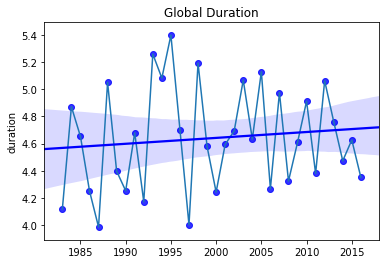

In [20]:
data = df.groupby(['year'])['duration'].mean()
plt.plot(data)
sns.regplot(years, data, color = 'blue')

plt.title('Global Duration')

Text(0.5, 1.0, 'Global Intensity')

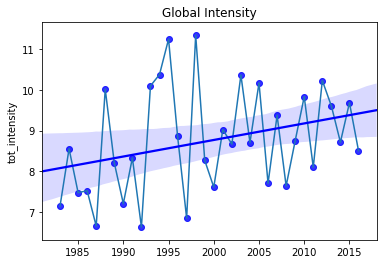

In [21]:
data = df.groupby(['year'])['tot_intensity'].mean()
plt.plot(data)
sns.regplot(years, data, color = 'blue')
plt.title('Global Intensity')

Text(0.5, 1.0, 'Global Severity')

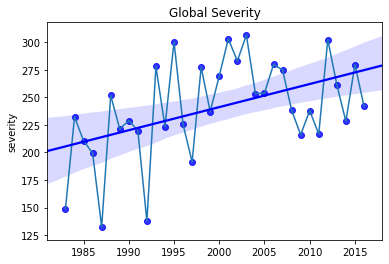

In [22]:
data = df.groupby(['year'])['severity'].mean()
plt.plot(data)
sns.regplot(years, data, color = 'blue')
plt.title('Global Severity')

Text(0.5, 1.0, 'Global Frequency per Year')

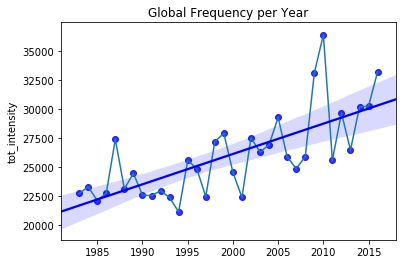

In [23]:
data = df.groupby(['year'])['tot_intensity'].count()
plt.plot(data)
sns.regplot(years, data, color = 'blue')
plt.title('Global Frequency per Year')

Text(0.5, 1.0, 'Global Total Days per year >40.6C')

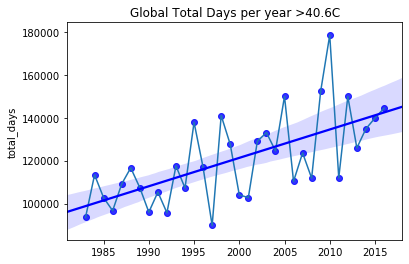

In [24]:
data = df.drop_duplicates(['year', 'ID_HDC_G0'], keep = 'first')
data = data.groupby('year')['total_days'].sum()
plt.plot(data)
sns.regplot(years, data, color = 'blue')
plt.title('Global Total Days per year >40.6C')

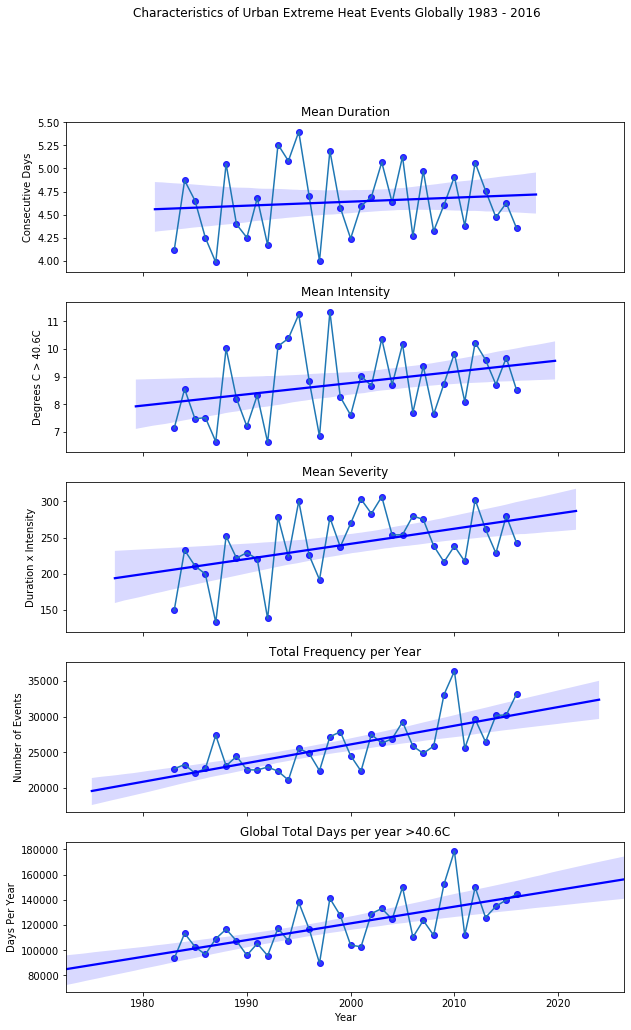

In [27]:
#### All stacked

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, figsize = (10,16), sharex=True)
fig.suptitle('Characteristics of Urban Extreme Heat Events Globally 1983 - 2016')

# Mean Duration
data = df.groupby(['year'])['duration'].mean()
ax1.plot(data)
sns.regplot(years, data, color = 'blue', ax = ax1)
ax1.set_title('Mean Duration')
ax1.set_ylabel('Consecutive Days')

# Mean Intensity
data = df.groupby(['year'])['tot_intensity'].mean()
ax2.plot(data)
sns.regplot(years, data, color = 'blue', ax = ax2)
ax2.set_title('Mean Intensity')
ax2.set_ylabel('Degrees C > 40.6C')

# Mean Severity 
data = df.groupby(['year'])['severity'].mean()
ax3.plot(data)
sns.regplot(years, data, color = 'blue', ax = ax3)
ax3.set_title('Mean Severity')
ax3.set_ylabel('Duration x Intensity')

# Total Number of Events 
data = df.groupby(['year'])['tot_intensity'].count()
ax4.plot(data)
sns.regplot(years, data, color = 'blue', ax = ax4)
ax4.set_title('Total Frequency per Year')
ax4.set_ylabel('Number of Events')

# Total Number of Days Per Year 
data = df.drop_duplicates(['year', 'ID_HDC_G0'], keep = 'first')
data = data.groupby('year')['total_days'].sum()
ax5.plot(data)
sns.regplot(years, data, color = 'blue', ax = ax5)
ax5.set_title('Global Total Days per year >40.6C')
ax5.set_ylabel('Days Per Year')
ax5.set_xlabel('Year')

# Set year axes
for ax in fig.get_axes():
    ax.label_outer()
    
# Fig save
# plt.savefig(FIG_OUT+'Fig1_v1')

# What are the trends by region?

In [83]:
regions = np.unique(df['sub-region'])
for region in regions:
    print(region)

Australia and New Zealand
Central Asia
Eastern Asia
Eastern Europe
Latin America and the Caribbean
Northern Africa
Northern America
Northern Europe
South-eastern Asia
Southern Asia
Southern Europe
Sub-Saharan Africa
Western Asia
Western Europe


In [148]:
data_list = []

for region in regions:
    data = df[df['sub-region'] == region]
    
    # Counts Days
#     data = data.drop_duplicates(['year', 'ID_HDC_G0'], keep = 'first')
#     data = data.groupby('year')['total_days'].sum()
    
    # Avgs
    #data = data.groupby('year')['severity'].mean()
    
    # Wgt-ed avts
    data = data.groupby('year').apply(lambda x: np.average(x['severity'], weights=x['P15']))
    
    # Population
    
    data_list.append(data)

Text(0.5, 0.98, 'Annual Avg. Severity of Urban Extreme Heat Events 1983 - 2016')

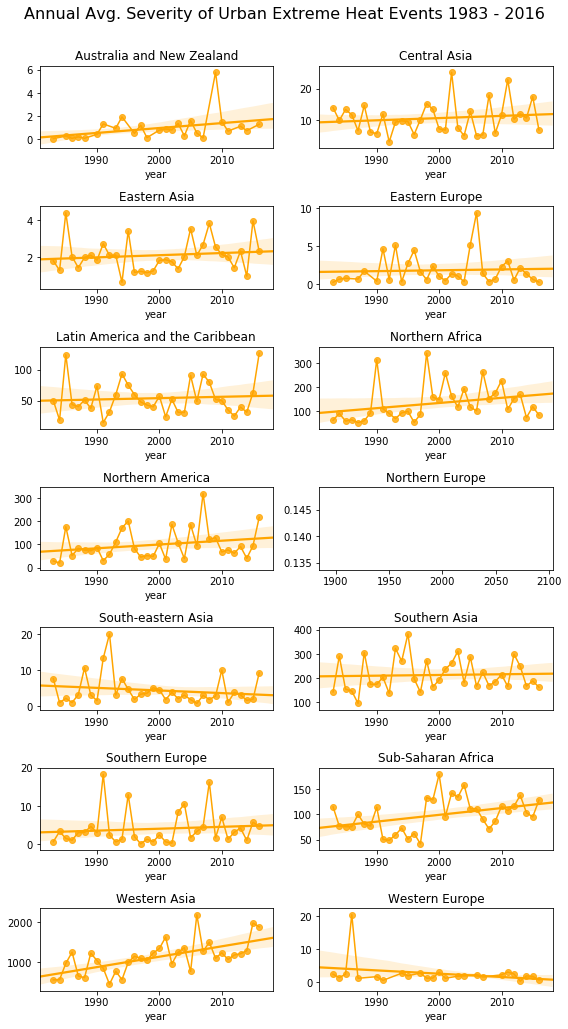

In [149]:
# Make subplots axes
fig, axs = plt.subplots(7,2, figsize=(8, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

color = 'Orange'

# Get subplot axes list
axs = axs.ravel()

for i in range(14):
    axs[i].title.set_text(regions[i])
    axs[i].plot(data_list[i], color = color)
    if len(data_list[i]) > 2:
        years = data_list[i].index
        data = list(data_list[i])
        sns.regplot(years, data, color = color, ax = axs[i])

# Plot details       
# plt.tight_layout()
# plt.subplots_adjust(top=0.85)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Annual Avg. Severity of Urban Extreme Heat Events 1983 - 2016', fontsize=16)

#plt.savefig(FIG_OUT+'Region-Freq.png')

In [78]:
data_list[2]

year
1983     84
1984     42
1985     21
1986    106
1987     63
1988    133
1989     65
1990    132
1991     42
1992     63
1993     40
1994    101
1995     72
1996    119
1997    175
1998    113
1999    147
2000    197
2001    124
2002    433
2003    252
2004    168
2005    371
2006    190
2007     86
2008     95
2009    217
2010    244
2011    196
2012    137
2013    166
2014    203
2015    152
2016    168
Name: ID_HDC_G0, dtype: int64

#### Frequency by region

Text(0, 0.5, 'Frequency of heat waves per year')

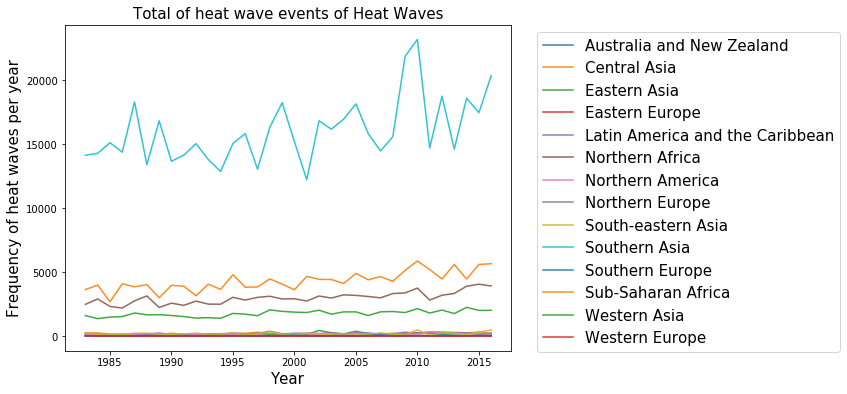

In [33]:
# plot by region 
ylabel = 'Frequency of heat waves per year'

fig, ax = plt.subplots(figsize=(8,6))
labels = []
for label, df_c in df.groupby('sub-region'):
    data = df_c.groupby('year')['ID_HDC_G0'].count()
    labels.append(label)
    plt.plot(data, alpha = 0.9)

plt.legend(labels, bbox_to_anchor=(1.04,1), loc="upper left", fontsize = 15)
plt.title('Total of heat wave events of Heat Waves', fontsize = 15)
plt.xlabel('Year', fontsize = 15)
plt.ylabel(ylabel, fontsize = 15)
#plt.ylabel('Number of Heat Waves', fontsize = 15)

#### Duration by region

In [ ]:
# plot by region 
ylabel = 'Annual average duration of heat waves per year'

fig, ax = plt.subplots(figsize=(8,6))
labels = []
for label, df_c in df.groupby('sub-region'):
    data = df_c.groupby('year')['duration'].mean()
    labels.append(label)
    plt.plot(data, alpha = 0.9)

plt.legend(labels, bbox_to_anchor=(1.04,1), loc="upper left", fontsize = 15)
plt.title('Total of heat wave events of Heat Waves', fontsize = 15)
plt.xlabel('Year', fontsize = 15)
plt.ylabel(ylabel, fontsize = 15)
#plt.ylabel('Number of Heat Waves', fontsize = 15)

#### Severity by region

In [ ]:
# plot by region 
ylabel = 'Annual average severity of heat waves per year'

fig, ax = plt.subplots(figsize=(8,6))
labels = []
for label, df_c in df.groupby('sub-region'):
    data = df_c.groupby('year')['severity'].mean()
    labels.append(label)
    plt.plot(data, alpha = 0.9)

plt.legend(labels, bbox_to_anchor=(1.04,1), loc="upper left", fontsize = 15)
plt.title('Annual average severity of heat waves per year', fontsize = 15)
plt.xlabel('Year', fontsize = 15)
plt.ylabel(ylabel, fontsize = 15)
#plt.ylabel('Number of Heat Waves', fontsize = 15)

#### Intensity by region

In [ ]:
# plot by region 
ylabel = 'Annual average total intensity of heat waves per year'

fig, ax = plt.subplots(figsize=(8,6))
labels = []
for label, df_c in df.groupby('sub-region'):
    data = df_c.groupby('year')['tot_intensity'].mean()
    labels.append(label)
    plt.plot(data, alpha = 0.9)

plt.legend(labels, bbox_to_anchor=(1.04,1), loc="upper left", fontsize = 15)
plt.title('Annual average total intensity of heat waves per year', fontsize = 15)
plt.xlabel('Year', fontsize = 15)
plt.ylabel(ylabel, fontsize = 15)
#plt.ylabel('Number of Heat Waves', fontsize = 15)

#### Days per year by region

In [ ]:
# plot by region 
ylabel = 'Avg number of days per year'

fig, ax = plt.subplots(figsize=(8,6))
labels = []
for label, df_c in df.groupby('sub-region'):
    data = df_c.drop_duplicates(['year', 'ID_HDC_G0'], keep = 'first')
    data = data.groupby('year')['total_days'].sum()
    labels.append(label)
    plt.plot(data, alpha = 0.9)

plt.legend(labels, bbox_to_anchor=(1.04,1), loc="upper left", fontsize = 15)
plt.title('Avg total of days per year Tmax >40.6C by city', fontsize = 15)
plt.xlabel('Year', fontsize = 15)
plt.ylabel(ylabel, fontsize = 15)


# Check regions individually

In [ ]:
# plot by region 
ylabel = 'Days per year >40.6C'
geog = 'sub-region'
region = 'Sub-Saharan Africa'

fig, ax = plt.subplots(figsize=(8,6))
labels = [region]
data = df[df[geog] == region]
data = data.drop_duplicates(['year', 'ID_HDC_G0'], keep = 'first')
data = data.groupby('year')['total_days'].sum()
# data = data.groupby('year')['avg_temp'].count()
labels.append(region)
plt.plot(data, alpha = 0.9)

plt.legend(labels, bbox_to_anchor=(1.04,1), loc="upper left", fontsize = 15)
plt.title('Total of heat wave events of Heat Waves', fontsize = 15)
plt.xlabel('Year', fontsize = 15)
plt.ylabel(ylabel, fontsize = 15)

# Plots by each event start date

In [ ]:
india = df[df['CTR_MN_NM'] == 'India']

In [ ]:
y = india['duration']
x = pd.to_datetime(india['start_date'])

In [ ]:
plt.scatter(x,y, alpha = 0.1)

# Population and Area Weighted Totals
see: https://pbpython.com/weighted-average.html

In [151]:
# styles
kwargs = {'linewidth':0.7, 'marker': 'o'} #linestyle: '--'

In [ ]:
data = df.groupby(['year']).apply(lambda x: np.average(x['duration'], weights=x['P15']))
plt.plot(data, **kwargs)
plt.title('Global Populuation-Weighted Avg. Duration')
plt.ylabel('Duration (days)')

In [ ]:
data = df.groupby(['year']).apply(lambda x: np.average(x['tot_intensity'], weights=x['P15']))
plt.plot(data, **kwargs)
plt.title('Global Populuation-Weighted Avg. Intensity')
plt.ylabel('Sum Tmax > 40.6C')

In [ ]:
data = df.groupby(['year']).apply(lambda x: np.average(x['severity'], weights=x['P15']))
plt.plot(data, **kwargs)
plt.title('Global Populuation-Weighted Avg. Severity')
plt.ylabel('Duration x Tot. Intensity')

In [ ]:
data = df.groupby(['year']).apply(lambda x: np.average(x['avg_temp'], weights=x['P15']))
plt.plot(data, **kwargs)
plt.title('Global Populuation-Weighted Avg. Temp')
plt.ylabel('Degrees C')

In [ ]:
# Weighted count num of events by pop

data = pd.DataFrame(df.groupby(['year', 'ID_HDC_G0'])['tot_intensity'].count()) # group by year and then ID and count
data = data.swaplevel() # fix the levels
data.reset_index(level=['year', 'ID_HDC_G0'], inplace=True) # reset index
data.rename(columns={'tot_intensity':'event_counts'}, inplace=True) # rename

# get pop weights
wgt = df_pop[['ID_HDC_G0', 'P15_wgt']]
data = pd.merge(data, wgt, on = 'ID_HDC_G0', how = 'inner')
data['count_wgt'] = data['event_counts'] * data['P15_wgt']
print(len(data))

## plot it 
data = data.groupby('year')['count_wgt'].sum()
plt.plot(data, **kwargs)
plt.title('Global Population-Weighted Frequency per Year')
plt.ylabel('Population-weighted Frequency of Events')


In [ ]:
# Weighted number of days num of events by pop

data = df.drop_duplicates(['year', 'ID_HDC_G0'], keep = 'first') # drop out duplicates
data = data[['ID_HDC_G0', 'year', 'total_days']] # Get Data
wgt = df_pop[['ID_HDC_G0', 'P15_wgt']] # Get pop weights
data = pd.merge(data, wgt, on = 'ID_HDC_G0', how = 'inner') # merge
data['days_wgt'] = data['total_days'] * data['P15_wgt'] # calc day weights

## plot it 
data = data.groupby('year')['days_wgt'].sum()
plt.plot(data, **kwargs)
plt.title('Global Population-Weighted Tot Number of Days per year >40.6')
plt.ylabel('Population-weighted Num of \n Days per year >40.6c')

# All plots in one

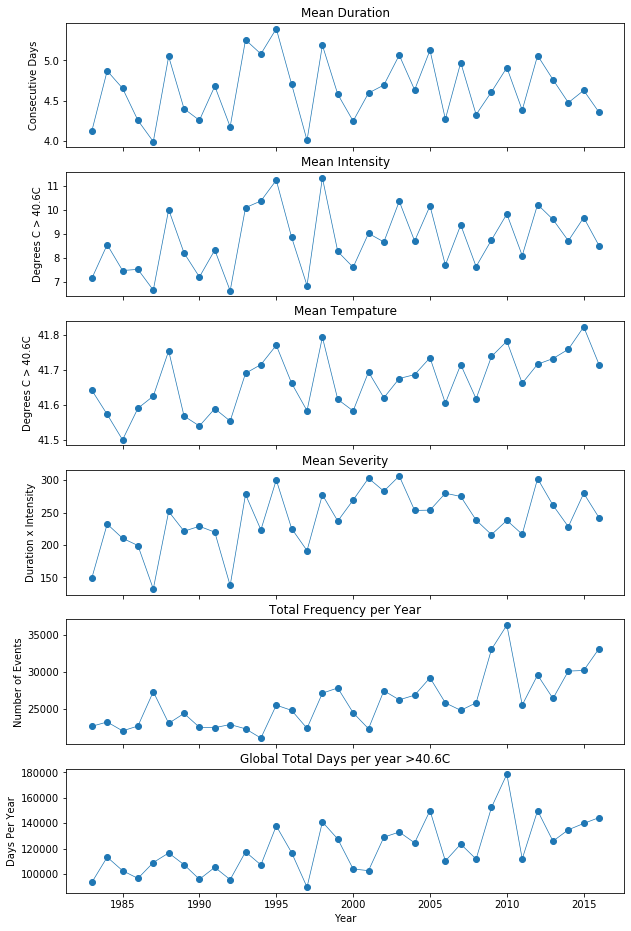

In [162]:
#### All stacked no weights

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, figsize = (10,16), sharex=True)
#fig.suptitle('Characteristics of Urban Extreme Heat Events Globally 1983 - 2016')

# Mean Duration
data = df.groupby(['year'])['duration'].mean()
ax1.plot(data, **kwargs)
ax1.set_title('Mean Duration')
ax1.set_ylabel('Consecutive Days')

# Mean Intensity
data = df.groupby(['year'])['tot_intensity'].mean()
ax2.plot(data, **kwargs)
ax2.set_title('Mean Intensity')
ax2.set_ylabel('Degrees C > 40.6C')

# Mean Temp
data = df.groupby(['year'])['avg_temp'].mean()
ax3.plot(data, **kwargs)
ax3.set_title('Mean Tempature')
ax3.set_ylabel('Degrees C > 40.6C')

# Mean Severity 
data = df.groupby(['year'])['severity'].mean()
ax4.plot(data, **kwargs)
ax4.set_title('Mean Severity')
ax4.set_ylabel('Duration x Intensity')

# Total Number of Events 
data = df.groupby(['year'])['tot_intensity'].count()
ax5.plot(data, **kwargs)
ax5.set_title('Total Frequency per Year')
ax5.set_ylabel('Number of Events')

# Total Number of Days Per Year 
data = df.drop_duplicates(['year', 'ID_HDC_G0'], keep = 'first')
data = data.groupby('year')['total_days'].sum()
ax6.plot(data, **kwargs)
ax6.set_title('Global Total Days per year >40.6C')
ax6.set_ylabel('Days Per Year')
ax6.set_xlabel('Year')

# Set year axes
for ax in fig.get_axes():
    ax.label_outer()
    
# Fig save
#plt.savefig(FIG_OUT+'Fig1_v1_nowgt')

In [178]:
axs[0][0]

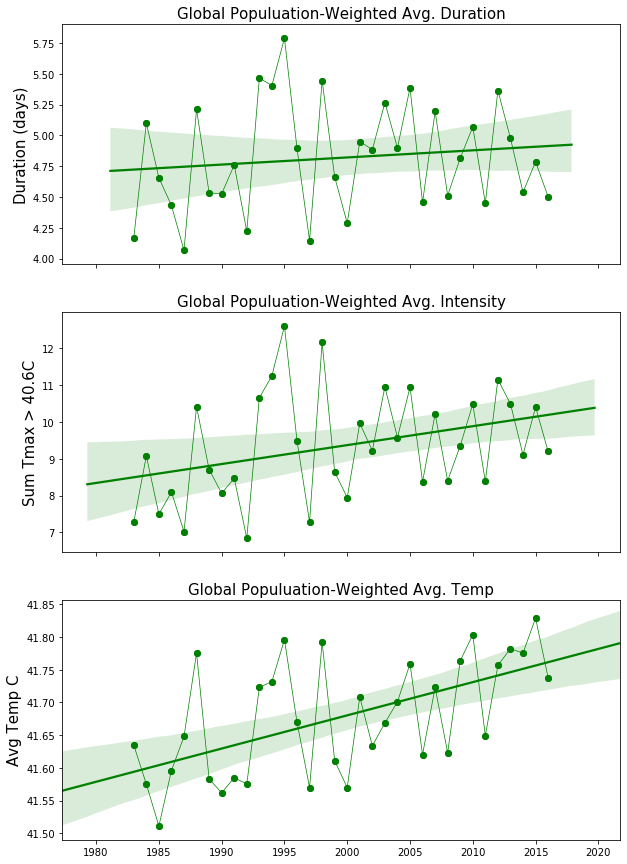

In [193]:
#### All stacked pop weights

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize = (10,15), sharex=True)
#fig.suptitle('Characteristics of Urban Extreme Heat Events Globally 1983 - 2016')

years = np.unique(df['year'])

# Mean Duration
data = df.groupby(['year']).apply(lambda x: np.average(x['duration'], weights=x['P15']))
ax1.plot(data, **kwargs, color = 'Green')
sns.regplot(years, data, color = 'Green', ax = ax1)

ax1.set_title('Global Populuation-Weighted Avg. Duration', fontsize = 15)
ax1.set_ylabel('Duration (days)', fontsize = 15)

# Mean Intensity
data = df.groupby(['year']).apply(lambda x: np.average(x['tot_intensity'], weights=x['P15']))
ax2.plot(data, **kwargs, color = 'Green')
sns.regplot(years, data, color = 'Green', ax = ax2)
ax2.set_title('Global Populuation-Weighted Avg. Intensity', fontsize = 15)
ax2.set_ylabel('Sum Tmax > 40.6C', fontsize = 15)

# Mean Temp
data = df.groupby(['year']).apply(lambda x: np.average(x['avg_temp'], weights=x['P15']))
ax3.plot(data, **kwargs, color = 'Green')
sns.regplot(years, data, color = 'Green', ax = ax3)
ax3.set_title('Global Populuation-Weighted Avg. Temp', fontsize = 15)
ax3.set_ylabel('Avg Temp C', fontsize = 15)


# Set year axes
for ax in fig.get_axes():
    ax.label_outer()
    
# Fig save
plt.savefig(FIG_OUT+'Fig1_1_popwgt')

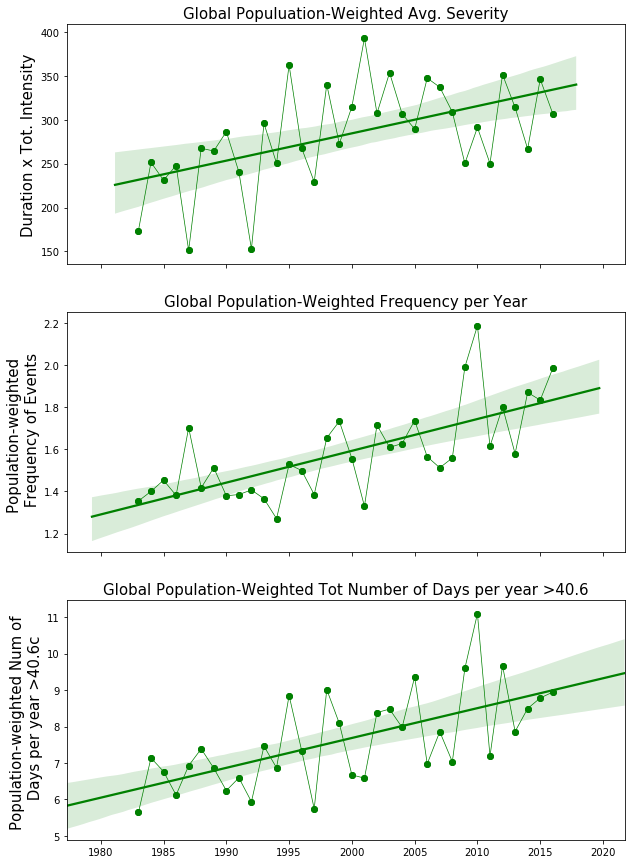

In [195]:
#### All stacked pop weights

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize = (10,15), sharex=True)
#fig.suptitle('Characteristics of Urban Extreme Heat Events Globally 1983 - 2016')

years = np.unique(df['year'])

# Mean Severity 
data = df.groupby(['year']).apply(lambda x: np.average(x['severity'], weights=x['P15']))
ax1.plot(data, **kwargs, color = 'Green')
sns.regplot(years, data, color = 'Green', ax = ax1)
ax1.set_title('Global Populuation-Weighted Avg. Severity', fontsize = 15)
ax1.set_ylabel('Duration x Tot. Intensity', fontsize = 15)

# Total Number of Events 
data = pd.DataFrame(df.groupby(['year', 'ID_HDC_G0'])['tot_intensity'].count()) # group by year and then ID and count
data = data.swaplevel() # fix the levels
data.reset_index(level=['year', 'ID_HDC_G0'], inplace=True) # reset index
data.rename(columns={'tot_intensity':'event_counts'}, inplace=True) # rename

wgt = df_pop[['ID_HDC_G0', 'P15_wgt']]
data = pd.merge(data, wgt, on = 'ID_HDC_G0', how = 'inner')
data['count_wgt'] = data['event_counts'] * data['P15_wgt']

data = data.groupby('year')['count_wgt'].sum()
ax2.plot(data, **kwargs, color = 'Green')
sns.regplot(years, data, color = 'Green', ax = ax2)
ax2.set_title('Global Population-Weighted Frequency per Year', fontsize = 15)
ax2.set_ylabel('Population-weighted \n Frequency of Events', fontsize = 15)

# Total Number of Days Per Year 
data = df.drop_duplicates(['year', 'ID_HDC_G0'], keep = 'first') # drop out duplicates
data = data[['ID_HDC_G0', 'year', 'total_days']] # Get Data
wgt = df_pop[['ID_HDC_G0', 'P15_wgt']] # Get pop weights
data = pd.merge(data, wgt, on = 'ID_HDC_G0', how = 'inner') # merge
data['days_wgt'] = data['total_days'] * data['P15_wgt'] # calc day weights


data = data.groupby('year')['days_wgt'].sum()
ax3.plot(data, **kwargs, color = 'Green')
sns.regplot(years, data, color = 'Green', ax = ax3)
ax3.set_title('Global Population-Weighted Tot Number of Days per year >40.6', fontsize = 15)
ax3.set_ylabel('Population-weighted Num of \n Days per year >40.6c', fontsize = 15)

# Set year axes
for ax in fig.get_axes():
    ax.label_outer()

plt.savefig(FIG_OUT+'Fig1_2_popwgt')

In [ ]:
#### All stacked area weights

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, figsize = (10,16), sharex=True)
#fig.suptitle('Characteristics of Urban Extreme Heat Events Globally 1983 - 2016')

# Mean Duration

data = df.groupby(['year']).apply(lambda x: np.average(x['duration'], weights=x['AREA']))
ax1.plot(data, **kwargs, color = 'Red')
ax1.set_title('Global Populuation-Weighted Avg. Duration')
ax1.set_ylabel('Duration (days)')

# Mean Intensity
data = df.groupby(['year']).apply(lambda x: np.average(x['tot_intensity'], weights=x['AREA']))
ax2.plot(data, **kwargs, color = 'Red')
ax2.set_title('Global Populuation-Weighted Avg. Intensity')
ax2.set_ylabel('Sum Tmax > 40.6C')

# Mean Temp
data = df.groupby(['year']).apply(lambda x: np.average(x['avg_temp'], weights=x['AREA']))
ax3.plot(data, **kwargs, color = 'Red')
ax3.set_title('Global Populuation-Weighted Avg. Temp')
ax3.set_ylabel('Avg Temp C')

# Mean Severity 
data = df.groupby(['year']).apply(lambda x: np.average(x['severity'], weights=x['AREA']))
ax4.plot(data, **kwargs, color = 'Red')
ax4.set_title('Global Populuation-Weighted Avg. Severity')
ax4.set_ylabel('Duration x Tot. Intensity')

# Total Number of Events 
data = pd.DataFrame(df.groupby(['year', 'ID_HDC_G0'])['tot_intensity'].count()) # group by year and then ID and count
data = data.swaplevel() # fix the levels
data.reset_index(level=['year', 'ID_HDC_G0'], inplace=True) # reset index
data.rename(columns={'tot_intensity':'event_counts'}, inplace=True) # rename

wgt = df_pop[['ID_HDC_G0', 'AREA_wgt']]
data = pd.merge(data, wgt, on = 'ID_HDC_G0', how = 'inner')
data['count_wgt'] = data['event_counts'] * data['AREA_wgt']

data = data.groupby('year')['count_wgt'].sum()
ax5.plot(data, **kwargs, color = 'Red')
ax5.set_title('Global Population-Weighted Frequency per Year')
ax5.set_ylabel('Population-weighted \n Frequency of Events')

# Total Number of Days Per Year 
data = df.drop_duplicates(['year', 'ID_HDC_G0'], keep = 'first') # drop out duplicates
data = data[['ID_HDC_G0', 'year', 'total_days']] # Get Data
wgt = df_pop[['ID_HDC_G0', 'AREA_wgt']] # Get pop weights
data = pd.merge(data, wgt, on = 'ID_HDC_G0', how = 'inner') # merge
data['days_wgt'] = data['total_days'] * data['AREA_wgt'] # calc day weights


data = data.groupby('year')['days_wgt'].sum()
ax6.plot(data, **kwargs, color = 'Red')
ax6.set_title('Global Population-Weighted Tot Number of Days per year >40.6')
ax6.set_ylabel('Population-weighted Num of \n Days per year >40.6c')

# Set year axes
for ax in fig.get_axes():
    ax.label_outer()
    
# Fig save
plt.savefig(FIG_OUT+'Fig1_v1_areawgt')

# Regessions

-- double check this

In [ ]:
from numpy.polynomial.polynomial import polyfit

# make things easier for OLS
regressor = LinearRegression()  

# Geog 
geog = 'ID_HDC_G0'

# Set stat
stats = 'tot_intensity'

# Get results

labels = []
r2_list = []
coef_list = []
p_list = []
df_out = pd.DataFrame()

for label, df_c in df.groupby(geog):
    
    # Get Data
    X_year = np.array(df_c.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
    Y_stats = np.array(df_c.groupby('year')[stats].mean()).reshape((-1, 1))
    
    # Regress
    model = sm.OLS(Y_stats, X_year).fit()
    coef = model.params[0]
    r2 = model.rsquared_adj
    p = model.pvalues[0]
    
    # Make lists
    labels.append(label)
    r2_list.append(r2)
    coef_list.append(coef)
    p_list.append(p)
#     print(label)
#     print(model.summary())
    
# Make data frame
df_out[geog] = labels
df_out['r2'] = r2_list
df_out['coef'] = coef_list
df_out['p_value'] = [round(elem, 4) for elem in p_list]

In [ ]:
print('Reg. results for average annual', stats, 'by year 1983 - 2016')
df_out.sort_values(by = 'coef', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last').head(50)


In [ ]:
df_out_merge = df_out.merge(df, on = 'ID_HDC_G0', how = 'inner')
df_out_merge = df_out_merge.drop_duplicates('ID_HDC_G0')

In [ ]:
df_out_merge.sort_values(by = 'coef', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last').head(50)


In [ ]:
data = df[df[geog] == 'Iraq']
year = np.array(data.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
stats = np.array(data.groupby('year')['severity'].mean()).reshape((-1, 1))

In [ ]:
plt.plot(year, stats, **kwargs)

In [ ]:
# Get Data
X_year = np.array(data.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
Y_stats = np.array(data.groupby('year')['severity'].mean()).reshape((-1, 1))
    

In [ ]:
plt.plot(X_year, Y_stats)

In [ ]:
model = sm.OLS(Y_stats, X_year).fit()

model.params

# Exposure

In [196]:
pop = pd.read_csv(DATA_IN+'GHS-UCDB-Interp.csv')

In [197]:
pop.head()

,Unnamed: 0,P75,P76,P77,P78,P79,P80,P81,P82,P83,...,P07,P08,P09,P010,P011,P012,P013,P014,P15,ID_HDC_G0
0,0,76680.403870,76724.995508,76769.587146,76814.178784,76858.770422,76903.362061,76947.953699,76992.545337,77037.136975,...,72350.446021,71934.628198,71518.810376,71102.992554,70687.174731,70271.356909,69855.539087,69439.721265,69023.903442,5782
1,1,432518.760010,430308.818037,428098.876064,425888.934091,423678.992118,421469.050145,419259.108173,417049.166200,414839.224227,...,318454.849264,313888.948027,309323.046789,304757.145551,300191.244313,295625.343076,291059.441838,286493.540600,281927.639362,3316
2,2,83301.193208,82988.143283,82675.093359,82362.043434,82048.993509,81735.943584,81422.893660,81109.843735,80796.793810,...,83948.182861,85470.066025,86991.949188,88513.832352,90035.715515,91557.598679,93079.481842,94601.365005,96123.248169,5645
3,3,59961.838394,60449.793404,60937.748414,61425.703424,61913.658434,62401.613444,62889.568454,63377.523464,63865.478474,...,78346.800964,78991.555206,79636.309448,80281.063690,80925.817932,81570.572174,82215.326416,82860.080658,83504.834900,3185
4,4,216241.069946,215363.900885,214486.731824,213609.562762,212732.393701,211855.224640,210978.055579,210100.886517,209223.717456,...,169264.371629,167489.228621,165714.085614,163938.942607,162163.799599,160388.656592,158613.513584,156838.370577,155063.227570,3539


In [ ]:
# Rename columns



In [235]:
# Total Number of Days Per Year 
data = df.drop_duplicates(['year', 'ID_HDC_G0'], keep = 'first') # drop out duplicates

pdays = pd.DataFrame()
pdays['ID_HDC_G0'] = data['ID_HDC_G0']
pdays['year'] = data['year']
pdays['total_days'] = data['total_days']

#data = data.groupby('year')['total_days'].sum()

# data = data[['ID_HDC_G0', 'year', 'total_days']] # Get Data
# wgt = df_pop[['ID_HDC_G0', 'P15_wgt']] # Get pop weights
# data = pd.merge(data, wgt, on = 'ID_HDC_G0', how = 'inner') # merge
# data['days_wgt'] = data['total_days'] * data['P15_wgt'] # calc day weights


# data = data.groupby('year')['days_wgt'].sum()
# ax3.plot(data, **kwargs, color = 'Green')
# sns.regplot(years, data, color = 'Green', ax = ax3)
# ax3.set_title('Global Population-Weighted Tot Number of Days per year >40.6', fontsize = 15)
# ax3.set_ylabel('Population-weighted Num of \n Days per year >40.6c', fontsize = 15)


In [252]:
pop_long = pd.wide_to_long(pop, stubnames = 'P', i = 'ID_HDC_G0', j = 'year')
pop_long.reset_index(level=0, inplace=True)
pop_long.reset_index(level=0, inplace=True)

test = pop_long[pop_long['year'] == 75]
test

,year,ID_HDC_G0,Unnamed: 0,P
0,75,5782,0,76680.403870
1,75,3316,1,432518.760010
2,75,5645,2,83301.193208
3,75,3185,3,59961.838394
4,75,3539,4,216241.069946
...,...,...,...,...
13130,75,13046,13130,57779.133965
13131,75,1116,13131,40262.589729
13132,75,1114,13132,81200.346130
13133,75,1161,13133,18812.595520
